##### Copyright 2020 The Cirq Developers

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neutral Atom Device Class

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.example.org/cirq/tutorials/educators/neutral_atom"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on QuantumLib</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/tutorials/educators/neutral_atom.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/tutorials/educators/neutral_atom.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/educators/neutral_atom.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook provides an introductiong to making circuits that are compatable with neutral atom devices in Cirq. The NeutralAtomDevice class is available starting with release 0.5.0.

In [2]:
# install release containing NeutralAtomDevice and IonDevice classes
!pip install cirq~=0.5.0 --quiet

Let's get some imports out of the way and construct an instance of the NeutralAtomDevice class. We won't worry about the details of the constructor arguments just yet, we just want an instance of the class for demonstration purposes.

In [3]:
import cirq
import numpy as np
from matplotlib import pyplot as plt

ms = cirq.Duration(nanos=10**6)
us = cirq.Duration(nanos=10**3)
neutral_device = cirq.NeutralAtomDevice(measurement_duration = 5*ms,
                                       gate_duration = 100*us,
                                       control_radius = 2,
                                       max_parallel_z = 3,
                                       max_parallel_xy = 3,
                                       max_parallel_c = 3,
                                       qubits = [cirq.GridQubit(row, col) 
                                                 for col in range(3) 
                                                 for row in range(3)])

## NeutralAtomDevice
Disclaimer: As with any proposed architecture for quantum computing, several research groups around the world are working towards a device based on neutral atom qubits. Each research group has a different approach, such as using different atomic species or working with a different number of dimensions of atomic qubit arrays. As such, the NeutralAtomDevice class will not accurately reflect all such devices. The class is based on the two dimensional cesium array at the University of Wisconsin-Madison in the research group of Mark Saffman. Development of this device is being pursued as part of a strategic partnershp between the University of Wisconsin-Madison and ColdQuanta.


---

### Native Gate Set
The gates supported by the NeutralAtomDevice class can be placed in three categories:


1.   Single qubit rotations about the Z axis
2.   Single qubit rotations about an arbitrary axis in the X-Y plane (I refer to these as XY gates in this tutorial)
3.   Controlled gates: CZ, CNOT, CCZ, CCNOT (TOFFOLI)


For the single qubit rotations, any rotation angle is fine. However, for the controlled gates, the rotation must be a multiple of $\pi$ due to the physical implementation of the gates. Cirq supports raising gates to arbitrary exponents. In order to satisfy the restriction of the controlled gate rotation, the exponent of the controlled gate must be an integer.


You are allowed to specify the connectivity of the controlled gates via the control_radius argument of the NeutralAtomDevice constructor. This argument specifies the maximum distance between pairs of atoms acted on by a controlled gate. 


The neutral atom scheme for controlled gates also allows for multiple controls so long as every pair of atoms acted on by the controlled gate are close enough to eachother. The NeutralAtomDevice class does not currently support gates with greater than two controls  but we hope to implement support for them in the near term.


---


Some examples of gates in Cirq that the device supports are given below.

In [4]:
# Single Qubit Z rotation by Pi/5 radians
neutral_device.validate_gate(cirq.Rz(np.pi/5))
# Single Qubit rotation about axis in X-Y plane Pi/3 radians from X axis by angle of Pi/7
neutral_device.validate_gate(cirq.PhasedXPowGate(phase_exponent=np.pi/3,exponent=np.pi/7))
# Controlled gate with integer exponent 
neutral_device.validate_gate(cirq.CNOT)
# Controlled Not gate with two controls
neutral_device.validate_gate(cirq.TOFFOLI)

Some examples of gates in Cirq the device does not support are given below. These code blocks will yield errors describing since the gates are not valid for NeutralAtomDevice.

In [5]:
#Controlled gate with non-integer exponent (rotation angle must be a multiple of pi)
# neutral_device.validate_gate(cirq.CZ**1.5)

In [6]:
# Hadamard gates rotate about the X-Z axis, which isn't compatable with our single qubit rotations
# neutral_device.validate_gate(cirq.H)

### Constructor

Let's take a look at the constructor for the NeutralAtomDevice class. There are a number of arguments needed to fully parametarize a device. The specific values for these numbers are expected improve over time for any physical device. Instead of constraining ourselves to how the device(s) look at a specific moment in time, the user is allowed to free or constrain themselves as  they see fit.

---

Gate duration variables: Depending on the specific implementation of the quantum gate, there may be a different amount of time needed to perform various actions. These arguments accept Duration and timedelta objects.

*   measurement_duration: How long it takes for the device to measure a qubit

*   gate_duration: The maximum amount of time it takes to execute a quantum gate

---

Parallelism limitations: Neutral atom devices implement quantum gates in one of two ways. One method is by hitting the entire qubit array with microwaves to simultaneously act on every qubit. This method implements global XY gates which take up to 100 microseconds to perform. Alternatively, we can shine laser light on some fraction of the array. Gates of this type typically take around 1 microsecond to perform. This method can act on one or more qubits at a time up to some limit dictated by the available laser power and the beam steering system used to address the qubits. Each category in the native gate set has its own limit.


*   max_parallel_z: The maximum number of single qubit Z-axis rotations that can be applied in parallel

*   max_parallel_xy: The maximum number of single qubit XY rotations that can be applied in parallel

*   max_parallel_c: The maximum number of atoms that can be affected by controlled gates simulataneously

Z-axis rotations and XY rotations use different light, so they have independent constraints. However, controlled gates make use of the light used to perform single qubit rotations in addition to extra laser frequencies. As such, the max_parallel_c argument is bounded above by the lesser of max_parallel_z and max_parallel_xy. 

---

Other variables:

*   qubits: A list of the qubits on the device. The only supported qubit type is GridQubit.

*   control_radius: Every pair of atoms acted on by a controlled gate must be within this maximum distance of eachother for the gate to succeed. The distance is between qubits is measured by using their row and column values as coordinates.


---

The example device below has the following properties:

*   The device is a 3x3 grid of qubits
*   Measurements take 5ms
*   Gates may take as long as 100us if we utilize global microwave gates. Otherwise, a more reasonable bound would be 1us.
*   Controlled gates have next-nearest neighbor connectivity (control_radius of 2)
*   A maximum of 3 qubits may be simultaneously acted on by any gate category 


In [7]:
ms = cirq.Duration(nanos=10**6)
us = cirq.Duration(nanos=10**3)
neutral_device = cirq.NeutralAtomDevice(measurement_duration = 5*ms,
                                       gate_duration = 100*us,
                                       control_radius = 2,
                                       max_parallel_z = 3,
                                       max_parallel_xy = 3,
                                       max_parallel_c = 3,
                                       qubits = [cirq.GridQubit(row, col) 
                                                 for col in range(3) 
                                                 for row in range(3)])

### Moment/Circuit Rules

Now that we know how to parametarize a NeutralAtomDevice, we can discuss some examples of valid and invalid moments and circuits. Each operation in a moment is treated as if they are performed simultaneously. This leaves us with a few constraints we need to abide by.


1.   We need to respect the maximum number of parallel gates for any gate type as discussed above
2.   All instances of gates in the same category in the same moment must be identical
3.   Since controlled gates make use of all types of light used to make gates, controlled gates cannot be applied in parallel with other gate types
4.   Qubits acted on by different controlled gates in parallel must be farther apart than control_radius so that the entanglement mechanism doesn't cause the gates to interfere with one another
5.   Measurements must be terminal



---

Some examples of valid moments are given below. We know the moments we constructed were valid because the circuit allowed us to add them knowing that they needed to pass the neutral_device validation methods.

In [8]:
# Moment/Circuit Examples
moment_circ = cirq.Circuit(device=neutral_device)
qubits = [cirq.GridQubit(row, col) for col in range(3) for row in range(3)]

# Three qubits affected by a Z gate in parallel with Three qubits affected
# by an XY gate
operation_list_one = cirq.Z.on_each(*qubits[:3])+cirq.X.on_each(*qubits[3:6])
valid_moment_one = cirq.Moment(operation_list_one)
moment_circ.append(valid_moment_one)

# A TOFFOLI gate on three qubits that are close enough to eachother
operation_list_two = [cirq.TOFFOLI.on(*qubits[:3])]
valid_moment_two = cirq.Moment(operation_list_two)
moment_circ.append(valid_moment_two)


print(moment_circ)

(0, 0): ───Z───@───
               │
(0, 1): ───X───┼───
               │
(1, 0): ───Z───@───
               │
(1, 1): ───X───┼───
               │
(2, 0): ───Z───X───

(2, 1): ───X───────


Frequently, you aren't explicitly constructing moments and adding them into circuits. You may more frequently find  yourself directly appending a list of operations into the circuit. Let's look at the result if we attempt this method with a global operation.

In [9]:
global_circuit = cirq.Circuit(device=neutral_device)
global_list_of_operations = cirq.X.on_each(*qubits)
global_circuit.append(global_list_of_operations)
print(global_circuit)

(0, 0): ───X───────────

(0, 1): ───────X───────

(0, 2): ───────────X───

(1, 0): ───X───────────

(1, 1): ───────X───────

(1, 2): ───────────X───

(2, 0): ───X───────────

(2, 1): ───────X───────

(2, 2): ───────────X───


That doesn't look right! It looks like the insertion method tried to place the gates in one at a time and decided it needed three moments to satisfy the request. There are two ways of getting around this in Cirq. One is to manually construct the moment as above.

In [10]:
global_moment_circuit = cirq.Circuit(device=neutral_device)
global_moment = cirq.Moment(cirq.X.on_each(*qubits))
global_moment_circuit.append(global_moment)
print(global_moment_circuit)

(0, 0): ───X───

(0, 1): ───X───

(0, 2): ───X───

(1, 0): ───X───

(1, 1): ───X───

(1, 2): ───X───

(2, 0): ───X───

(2, 1): ───X───

(2, 2): ───X───


Another way to achieve this task is the ParallelGateOperation class. Most Operation objects correspond to a single gate acting on some qubits. The ParallelGateOperation class corresponds to multiple copies of a single gate acting on some qubits in parallel. Since it is a single operation, the default insertion methods won't break it up into multiple moments when adding it into the circuit!

In [11]:
parallel_gate_op_circuit = cirq.Circuit(device=neutral_device)
parallel_gate_op = cirq.ParallelGateOperation(cirq.X,qubits)
parallel_gate_op_circuit.append(parallel_gate_op)
print(parallel_gate_op_circuit)

(0, 0): ───X───

(0, 1): ───X───

(0, 2): ───X───

(1, 0): ───X───

(1, 1): ───X───

(1, 2): ───X───

(2, 0): ───X───

(2, 1): ───X───

(2, 2): ───X───


###Grover's Algorithm
Now that we have the details out of the way, we can take a look at what implementing a real quantum algorithm might look like on a NeutralAtomDevice. Since the current limit on having multiple controls on a gate is two, lets look at the three qubit Grover search. For this problem, there is some special target state out of the $N = 2^n$ possible basis states that we'd like to identify. We have access to a quantum oracle that applies a phase to this state relative to every other basis state. The algorithm succeeds if we measure the desired state when we make a measurement on all the qubits after the circuit is run.


---

Classically, this corresponds to an unordered database search with a database of size $N=2^n$. On average, it will take $N/2$ applications of a classical oracle to find the desired state in the database. With Grover's algorithm, it is possible to succeed with high probability in $O(\sqrt N)$ applications of the quantum oracle.


---

Grover's algorithm works by initially preparing the quantum state
$$|s\rangle = \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}{|x\rangle}_.$$

This is an even superposition of each state in the computational basis and can be obtained by applying a Hadamard gate or a $Y^{1/2}$ gate on a register with each qubit initialized to $|0\rangle$. After this initial state is prepared, Grover's algorithm consists of applying the quantum oracle followed by a diffusion operator. 

The quantum oracle places a relative phase on the target state we want to measure and the diffusion operator utilizes that phase difference to amplify the probability of measuring the target state relative to other states in the computational basis.
The diffusion operator is given by $U_s = 2 |s\rangle \langle s| - I.$


---


We can calculate the probability of success as a function of the number of repititions R that we apply the oracle and diffusion operator. The result is $$P_{success} = \sin^2 ((2R+1)\arcsin(\frac{1}{\sqrt{N}})_,$$
with the maximum probability of success will occur when $R \approx \pi \sqrt{N}/4.$ 


---

We know what these operators look like in Dirac notation, but now we have to compile them into the language of quantum gates. We'll start with the oracle. We can construct the oracle out of controlled-Z gates and NOT (X) gates. A Controlled-Z gate applies a $\pi$ phase shift to the state where each qubit is in the $|1 \rangle $ state. We can select a different state to recieve the phase shift by sandwiching the controlled-Z gate with X gates on any of the qubits whose desired measurement outcome is $|0 \rangle$. We can implement a generator for the oracle operator with the below code in Cirq.

In [12]:
def oracle(qubits, key_bits):
    yield (cirq.X(q) for (q, bit) in zip(qubits, key_bits) if not bit)
    yield cirq.CCZ(*qubits)
    yield (cirq.X(q) for (q, bit) in zip(qubits, key_bits) if not bit)

# Try changing the key to see the relationship between
# the placement of the X gates and the key
key = (1, 0, 1)
qubits = [cirq.GridQubit(0,col) for col in range(3)]
oracle_example_circuit = cirq.Circuit().from_ops(oracle(qubits,key))
print(oracle_example_circuit)

(0, 0): ───────@───────
               │
(0, 1): ───X───@───X───
               │
(0, 2): ───────@───────


A quick Google search of how to implement the diffusion operator will provide us with the below implementation.

In [13]:
def diffusion_operator(qubits):
    yield cirq.H.on_each(*qubits)
    yield cirq.X.on_each(*qubits)
    yield cirq.CCZ(*qubits)
    yield cirq.X.on_each(*qubits)
    yield cirq.H.on_each(*qubits)
    
qubits = [cirq.GridQubit(0,col) for col in range(3)]
diffusion_circuit = cirq.Circuit().from_ops(diffusion_operator(qubits))
print(diffusion_circuit)

(0, 0): ───H───X───@───X───H───
                   │
(0, 1): ───H───X───@───X───H───
                   │
(0, 2): ───H───X───@───X───H───


If we put it all together and note that for the three qubit case, the optimal number of applications of the oracle and diffusion operator is two, we get the below circuit.

In [14]:
def initial_hadamards(qubits):
    yield cirq.H.on_each(*qubits)

uncompiled_circuit = cirq.Circuit()
key = (1,0,1)
qubits = [cirq.GridQubit(0,0),cirq.GridQubit(0,1),cirq.GridQubit(0,2)]
uncompiled_circuit.append(initial_hadamards(qubits))
uncompiled_circuit.append(oracle(qubits,key))
uncompiled_circuit.append(diffusion_operator(qubits))
uncompiled_circuit.append(oracle(qubits,key))
uncompiled_circuit.append(diffusion_operator(qubits))
print(uncompiled_circuit)

(0, 0): ───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───
                   │               │               │               │
(0, 1): ───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───
                   │               │               │               │
(0, 2): ───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───


This circuit does implement Grover's algorithm, but it doesn't work for our NeutralAtomDevice class because of the Hadamard gates. The Hadamard gates show up in the Diffusion Operator steps and the initial "Hadamard Everything" step. We can simplify the Diffusion Operator definition and the initial Hadamard step by decomposing the Hadamard gate into products of XY gates.


*   $H=X Y^{1/2}$ 
*   $H=Y^{-1/2} X$
*  $H=Y^{1/2}Z$

Using these two rules, we can instead make a neutral atom comptable version of the circuit given below.

In [15]:
def neutral_atom_initial_step(qubits):
    yield cirq.ParallelGateOperation(cirq.Y**(1/2), qubits)
    
def neutral_atom_diffusion_operator(qubits):
    yield cirq.ParallelGateOperation(cirq.Y**(1/2), qubits)
    yield cirq.CCZ(*qubits)
    yield cirq.ParallelGateOperation(cirq.Y**(-1/2), qubits)

    
ms = cirq.Duration(nanos=10**6)
us = cirq.Duration(nanos=10**3)
qubits = [cirq.GridQubit(row, col) for col in range(3) for row in range(1)]
three_qubit_device = cirq.NeutralAtomDevice(measurement_duration = 5*ms,
                                           gate_duration = us,
                                           control_radius = 2,
                                           max_parallel_z = 3,
                                           max_parallel_xy = 3,
                                           max_parallel_c = 3,
                                           qubits=qubits)
key = (0,1,0)
compiled_grover_circuit = cirq.Circuit(device=three_qubit_device)
compiled_grover_circuit.append(neutral_atom_initial_step(qubits))
compiled_grover_circuit.append(oracle(qubits,key))
compiled_grover_circuit.append(neutral_atom_diffusion_operator(qubits))
compiled_grover_circuit.append(oracle(qubits,key))
compiled_grover_circuit.append(neutral_atom_diffusion_operator(qubits))
print(compiled_grover_circuit)

(0, 0): ───Y^0.5───X───@───X───Y^0.5───@───Y^-0.5───X───@───X───Y^0.5───@───Y^-0.5───
                       │               │                │               │
(0, 1): ───Y^0.5───────@───────Y^0.5───@───Y^-0.5───────@───────Y^0.5───@───Y^-0.5───
                       │               │                │               │
(0, 2): ───Y^0.5───X───@───X───Y^0.5───@───Y^-0.5───X───@───X───Y^0.5───@───Y^-0.5───


Let's quickly verify that this implementation of the algorithm on our device actually works by altering the number of times we apply the oracle and diffusion operators. We would expect to reproduce the analytical result given above.

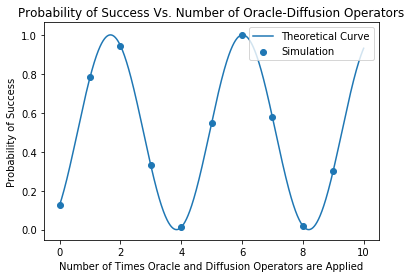

In [16]:
def grover_circuit_with_n_repetitions(n, key):
    ms = cirq.Duration(nanos=10**6)
    us = cirq.Duration(nanos=10**3)
    qubits = [cirq.GridQubit(row, col) for col in range(3) for row in range(1)]
    three_qubit_device = cirq.NeutralAtomDevice(measurement_duration = 5*ms,
                                               gate_duration = us,
                                               control_radius = 2,
                                               max_parallel_z = 3,
                                               max_parallel_xy = 3,
                                               max_parallel_c = 3,
                                               qubits=qubits)
    grover_circuit = cirq.Circuit(device=three_qubit_device)
    grover_circuit.append(neutral_atom_initial_step(qubits))
    for repetition in range(n):
      grover_circuit.append(oracle(qubits,key))
      grover_circuit.append(neutral_atom_diffusion_operator(qubits))
      
    return grover_circuit
      
success_probabilities = []
key = (0,1,1)
N = 2**3
#Convert key from binary to a base 10 number
diag = sum(2**(2-count) for (count, val) in enumerate(key) if val)
num_points = 10
for repetitions in range(num_points):
    test_circuit = grover_circuit_with_n_repetitions(repetitions, key)
    sim = cirq.Simulator()
    result = sim.simulate(test_circuit)
    rho = result.density_matrix_of(qubits)
    success_probabilities.append(np.real(rho[diag][diag]))

plt.scatter(range(num_points), success_probabilities, label="Simulation")
x = np.linspace(0, num_points, 1000)
y = np.sin((2*x+1)*np.arcsin(1/np.sqrt(N)))**2
plt.plot(x, y, label="Theoretical Curve")
plt.title("Probability of Success Vs. Number of Oracle-Diffusion Operators")
plt.ylabel("Probability of Success")
plt.xlabel("Number of Times Oracle and Diffusion Operators are Applied")
plt.legend(loc='upper right')
plt.show()

The results match! And we actually see that if we can afford to increase the number of times we apply the oracle and diffusion operators to six, we can get an improved probability of success.